In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")

from src.utils.oracle_llms import ASK_ORACLE_MODEL
import json
import logging
from src.utils import logging_utils
logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import numpy as np
import itertools
import networkx as nx
import random
import matplotlib.pyplot as plt

2025-05-16 14:14:34 matplotlib DEBUG    matplotlib data path: /opt/miniconda3/envs/retrieval-env/lib/python3.11/site-packages/matplotlib/mpl-data
2025-05-16 14:14:34 matplotlib DEBUG    CONFIGDIR=/Users/giordanorogers/.matplotlib
2025-05-16 14:14:34 matplotlib DEBUG    interactive is False
2025-05-16 14:14:34 matplotlib DEBUG    platform is darwin
2025-05-16 14:14:34 matplotlib DEBUG    CACHEDIR=/Users/giordanorogers/.matplotlib
2025-05-16 14:14:34 matplotlib.font_manager DEBUG    Using fontManager instance from /Users/giordanorogers/.matplotlib/fontlist-v390.json


In [4]:
def read_off_shape_file(path):
    """ Read OFF shapefile but ignore comment lines for. """
    with open(path) as f:
        if f.readline().strip() != "OFF":
            raise ValueError("Not an OFF file")
        # counts line
        while True:
            line = f.readline()
            if line.strip() and not line.lstrip().startswith("#"):
                n_v, n_f, _ = map(int, line.split())
                break
        # vertices
        verts = []
        while len(verts) < n_v:
            line = f.readline()
            if line.strip() and not line.lstrip().startswith("#"):
                verts.append(list(map(float, line.split())))
        verts = np.asarray(verts)
        # faces
        faces = []
        while len(faces) < n_f:
            line = f.readline()
            if line.strip() and not line.lstrip().startswith("#"):
                nums = list(map(int, line.split()))
                faces.append(nums[1 : 1 + nums[0]])
    return verts, faces

In [5]:
# Load the shape from the OFF file
try:
    verts, faces = read_off_shape_file("Icosahedron.off")
    logger.info(f"Loaded the shape: {len(verts)} vertices, {len(faces)} faces")

    # --- build vertex-adjacency graph --------------------------------------
    G_geo = nx.Graph()
    G_geo.add_nodes_from(range(len(verts)))          # 12 vertices ⇒ 12 nodes

    # collect unique edges from each triangular face
    edge_set = set()
    for face in faces:                               # each face has 3 vertices
        for u, v in itertools.combinations(face, 2): # 3 edges / face
            edge_set.add(tuple(sorted((u, v))))      # avoid duplicates

    G_geo.add_edges_from(edge_set)
    logger.info(f"Created graph with {G_geo.number_of_nodes()} nodes "
                f"and {G_geo.number_of_edges()} edges")

    # --- sanity-check the icosahedron structure ----------------------------
    if G_geo.number_of_nodes() != 12 or G_geo.number_of_edges() != 30:
        logger.warning("Graph doesn't match expected icosahedron "
                       "structure (12 nodes, 30 edges)")

    # (optional) store vertex degree (should be 5 everywhere)
    nx.set_node_attributes(G_geo,
                           {n: G_geo.degree(n) for n in G_geo.nodes},
                           name="degree")

except FileNotFoundError:
    logger.error("Could not find Icosahedron.off file")

2025-05-16 14:14:35 __main__ INFO     Loaded the shape: 12 vertices, 20 faces
2025-05-16 14:14:35 __main__ INFO     Created graph with 12 nodes and 30 edges


In [6]:
names = [
    "Amara Vellon",
    "Eamon Thistledown",
    "Calista Norwick",
    "Dorian Fairmont",
    "Isolde Brackenridge",
    "Lachlan Everfield",
    "Mirella Stonebridge",
    "Orin Hawkwell",
    "Soraya Bramble",
    "Thaddeus Elmworth",
    "Zelena Rookwood",
    "Bastian Crowther"
]

In [7]:
ids_to_entities = {i: name for i, name in enumerate(names)}
node_labels = ids_to_entities
print(node_labels)

{0: 'Amara Vellon', 1: 'Eamon Thistledown', 2: 'Calista Norwick', 3: 'Dorian Fairmont', 4: 'Isolde Brackenridge', 5: 'Lachlan Everfield', 6: 'Mirella Stonebridge', 7: 'Orin Hawkwell', 8: 'Soraya Bramble', 9: 'Thaddeus Elmworth', 10: 'Zelena Rookwood', 11: 'Bastian Crowther'}


In [8]:
attributes = [
    "nationality",
    "occupation",
    "university",
    "hobby",
    "pet",
    "car",
    "allergy",
    "favorite food",
    "favorite drink",
    "favorite color",
    "biggest fear"
]

In [9]:
def assign_unique_edge_attributes(G, attribute_list):
    """
    Assign edge attributes. Each node gets at most one connection of each attribute type.

    Args:
        G: Networkx graph
        attribute_list: List of possible attributes
    """
    # Trck which attributes are used for each node
    node_attributes = {node: set() for node in G.nodes()}

    # Create a list of edges to process
    ## Shuffle to randomize assignment order
    edges = list(G.edges())
    random.shuffle(edges)

    # Keep track of remaining attrbute options for each edge
    edge_attribute_options = {
        edge: set(attribute_list) for edge in edges
    }

    unassigned_edges = []

    # First pass: Try to assign attributes while maintaining uniqueness
    for edge in edges:
        u, v = edge
        # Find attributes that are still available for both nodes
        valid_attributes = [
            attr for attr in attribute_list 
            if attr not in node_attributes[u] and attr not in node_attributes[v]
        ]

        if valid_attributes:
            # If there are valid options, choose one randomly
            chosen_attr = random.choice(list(valid_attributes))
            G.edges[u, v]['label'] = chosen_attr

            # Mark this attribute as used for both nodes
            node_attributes[u].add(chosen_attr)
            node_attributes[v].add(chosen_attr)

        else:
            # If no valid options, leave for second pass
            unassigned_edges.append(edge)
            G.edges[u, v]['label'] = None

    if unassigned_edges:
        print(f"Warning: {len(unassigned_edges)} edges couldn't be assigned with strict uniqueness.")
        print(unassigned_edges)

    return G

In [10]:
# Validate that we have enough attributes for the degree of the graph
max_degree = max(dict(G_geo.degree()).values())
if len(attributes) < max_degree:
    logger.warning(f"Warning: Not enough unique attributes ({len(attributes)}) for nodes with degree {max_degree}.")
    logger.warning("Some connections will have to share attribute types.")

In [11]:
# Assign attributes to edges
if G_geo.number_of_edges() > 0:
    # Apply the unique attribute assignment
    G_geo = assign_unique_edge_attributes(G_geo, attributes)

    # Log the results
    logger.info("Edge attributes assigned with uniqueness constraints:")

    # Verify uniqueness and log connections
    attribute_counts = {}
    duplicates_found = False

    # For each node, show its connections and verify uniqueness
    for node in sorted(G_geo.nodes()):
        node_connections = {}
        node_name = ids_to_entities[node]

        # Collect all connections for this node
        for neighbor in G_geo.neighbors(node):
            attr = G_geo.edges[node, neighbor]['label']
            if attr in node_connections:
                duplicates_found = True
                logger.warning(f"DUPLICATE FOUND: {node_name} has multiple '{attr}' connections with {node_connections[attr]} and {ids_to_entities[neighbor]}")
            node_connections[attr] = ids_to_entities[neighbor]

        # Log this node's connections
        logger.info(f"Node {node} ({node_name}) connections:")
        for attr, neighbor in sorted(node_connections.items()):
            logger.info(f"  - {attr}: {neighbor}")
            attribute_counts[attr] = attribute_counts.get(attr, 0) + 1

    # Print statistics
    logger.info("Attribute usage statistics:")
    for attr, count in sorted(attribute_counts.items(), key=lambda x: x[1], reverse=True):
        logger.info(f"  - {attr}: used {count} times")
    
    if duplicates_found:
        logger.warning("Duplicates were found! Some nodes have multiple connections with the same attribute type.")
        logger.warning("Consider increasing the number of distinct attributes or accepting some duplicates.")
    else:
        logger.info("Success! All nodes have at most one connection of each attribute type.")

2025-05-16 14:15:02 __main__ INFO     Edge attributes assigned with uniqueness constraints:
2025-05-16 14:15:02 __main__ INFO     Node 0 (Amara Vellon) connections:
2025-05-16 14:15:02 __main__ INFO       - allergy: Zelena Rookwood
2025-05-16 14:15:02 __main__ INFO       - favorite color: Isolde Brackenridge
2025-05-16 14:15:02 __main__ INFO       - hobby: Mirella Stonebridge
2025-05-16 14:15:02 __main__ INFO       - nationality: Eamon Thistledown
2025-05-16 14:15:02 __main__ INFO       - occupation: Soraya Bramble
2025-05-16 14:15:02 __main__ INFO     Node 1 (Eamon Thistledown) connections:
2025-05-16 14:15:02 __main__ INFO       - biggest fear: Orin Hawkwell
2025-05-16 14:15:02 __main__ INFO       - favorite color: Zelena Rookwood
2025-05-16 14:15:02 __main__ INFO       - favorite food: Lachlan Everfield
2025-05-16 14:15:02 __main__ INFO       - nationality: Amara Vellon
2025-05-16 14:15:02 __main__ INFO       - pet: Soraya Bramble
2025-05-16 14:15:02 __main__ INFO     Node 2 (Calist

2025-05-16 14:15:02 __main__ INFO       - nationality: Mirella Stonebridge
2025-05-16 14:15:02 __main__ INFO     Node 11 (Bastian Crowther) connections:
2025-05-16 14:15:02 __main__ INFO       - favorite drink: Mirella Stonebridge
2025-05-16 14:15:02 __main__ INFO       - favorite food: Dorian Fairmont
2025-05-16 14:15:02 __main__ INFO       - hobby: Zelena Rookwood
2025-05-16 14:15:02 __main__ INFO       - occupation: Orin Hawkwell
2025-05-16 14:15:02 __main__ INFO       - pet: Calista Norwick
2025-05-16 14:15:02 __main__ INFO     Attribute usage statistics:
2025-05-16 14:15:02 __main__ INFO       - hobby: used 8 times
2025-05-16 14:15:02 __main__ INFO       - allergy: used 6 times
2025-05-16 14:15:02 __main__ INFO       - favorite color: used 6 times
2025-05-16 14:15:02 __main__ INFO       - nationality: used 6 times
2025-05-16 14:15:02 __main__ INFO       - occupation: used 6 times
2025-05-16 14:15:02 __main__ INFO       - biggest fear: used 6 times
2025-05-16 14:15:02 __main__ INFO

In [12]:
# Map attributes to natural language descriptions
edge_type_descriptions = {
    "nationality": "are from the same country",  
    "occupation": "work in the same field or profession",
    "university": "attended the same university",
    "hobby": "have the same hobby (not a sport or a game)",
    "pet": "have the same type of pet",
    "car": "have the same type of car",
    "allergy": "have the same type of allergy",
    "favorite food": "have the same favorite food",
    "favorite drink": "have the same favorite drink",
    "favorite color": "have the same favorite color",
    "biggest fear": "have the same same biggest fear"
}

In [13]:
print(ids_to_entities)

{0: 'Amara Vellon', 1: 'Eamon Thistledown', 2: 'Calista Norwick', 3: 'Dorian Fairmont', 4: 'Isolde Brackenridge', 5: 'Lachlan Everfield', 6: 'Mirella Stonebridge', 7: 'Orin Hawkwell', 8: 'Soraya Bramble', 9: 'Thaddeus Elmworth', 10: 'Zelena Rookwood', 11: 'Bastian Crowther'}


In [14]:
# Generate connection descriptions
connection_descriptions = []
for u, v, data in G_geo.edges(data=True):
    profile_u_name = ids_to_entities[u]
    profile_v_name = ids_to_entities[v]
    attribute_label = data['label']
    desc_phrase = edge_type_descriptions.get(attribute_label, f"share the attribute '{attribute_label}'")
    connection_descriptions.append(f"{profile_u_name} and {profile_v_name} {desc_phrase}.")

In [15]:
# Format the descriptions for the prompt
conn_desc_str = "\n".join([f"* {conn}" for conn in connection_descriptions])
logger.info(f"Generated {len(connection_descriptions)} connection descriptions")

2025-05-16 14:15:17 __main__ INFO     Generated 30 connection descriptions


In [16]:
logger.info("Connection descriptions:")
for i in range(len(connection_descriptions)):
    logger.info(connection_descriptions[i])

2025-05-16 14:15:18 __main__ INFO     Connection descriptions:
2025-05-16 14:15:18 __main__ INFO     Amara Vellon and Soraya Bramble work in the same field or profession.
2025-05-16 14:15:18 __main__ INFO     Amara Vellon and Eamon Thistledown are from the same country.
2025-05-16 14:15:18 __main__ INFO     Amara Vellon and Isolde Brackenridge have the same favorite color.
2025-05-16 14:15:18 __main__ INFO     Amara Vellon and Zelena Rookwood have the same type of allergy.
2025-05-16 14:15:18 __main__ INFO     Amara Vellon and Mirella Stonebridge have the same hobby (not a sport or a game).
2025-05-16 14:15:18 __main__ INFO     Eamon Thistledown and Lachlan Everfield have the same favorite food.
2025-05-16 14:15:18 __main__ INFO     Eamon Thistledown and Soraya Bramble have the same type of pet.
2025-05-16 14:15:18 __main__ INFO     Eamon Thistledown and Orin Hawkwell have the same same biggest fear.
2025-05-16 14:15:18 __main__ INFO     Eamon Thistledown and Zelena Rookwood have the s

2025-05-16 14:15:20 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-16 14:15:20 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.


2025-05-16 14:15:20 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-05-16 14:15:20 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/opt/miniconda3/envs/retrieval-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-05-16 14:15:20 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/opt/miniconda3/envs/retrieval-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-16 14:15:20 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/opt/miniconda3/envs/retrieval-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu

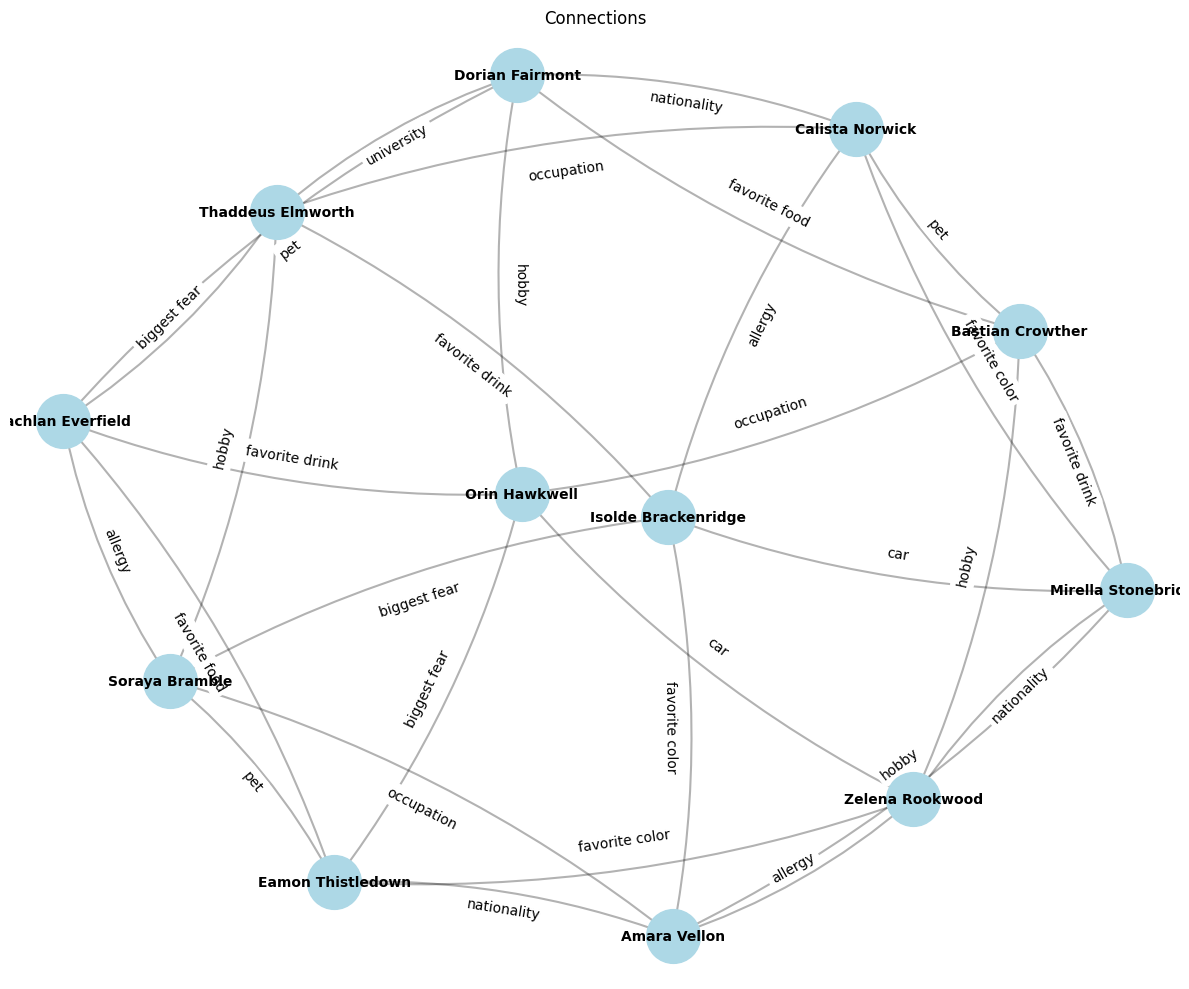

In [17]:
from src.data import draw_graph_with_minimal_edge_overlap

draw_graph_with_minimal_edge_overlap(G_geo, node_labels={i: name for i, name in enumerate(names)})


In [18]:
# Print each node's connections with their labels
print("connections:")
for node in G_geo.nodes():
    connections = [f"{ids_to_entities[neighbor]} ({G_geo[node][neighbor]['label']})" for neighbor in G_geo.neighbors(node)]
    print(f"{ids_to_entities[node]}: {connections}")

connections:
Amara Vellon: ['Soraya Bramble (occupation)', 'Eamon Thistledown (nationality)', 'Isolde Brackenridge (favorite color)', 'Zelena Rookwood (allergy)', 'Mirella Stonebridge (hobby)']
Eamon Thistledown: ['Amara Vellon (nationality)', 'Lachlan Everfield (favorite food)', 'Soraya Bramble (pet)', 'Orin Hawkwell (biggest fear)', 'Zelena Rookwood (favorite color)']
Calista Norwick: ['Bastian Crowther (pet)', 'Isolde Brackenridge (allergy)', 'Dorian Fairmont (nationality)', 'Thaddeus Elmworth (occupation)', 'Mirella Stonebridge (favorite color)']
Dorian Fairmont: ['Orin Hawkwell (hobby)', 'Thaddeus Elmworth (university)', 'Lachlan Everfield (pet)', 'Bastian Crowther (favorite food)', 'Calista Norwick (nationality)']
Isolde Brackenridge: ['Thaddeus Elmworth (favorite drink)', 'Mirella Stonebridge (car)', 'Soraya Bramble (biggest fear)', 'Calista Norwick (allergy)', 'Amara Vellon (favorite color)']
Lachlan Everfield: ['Orin Hawkwell (favorite drink)', 'Thaddeus Elmworth (biggest fear

In [19]:
with open("/Users/giordanorogers/Documents/Code/retrieval/data_save/synthetic_entities/newer_synthetic_entities.json", 'r') as f:
    demo_profiles = f.read()

print(demo_profiles)

[
    {
        "profile": {
            "name": "Elara Vance",
            "nationality": "Canadian",
            "occupation": "Data Scientist",
            "university": "University of Toronto",
            "degree": "Bachelor's in Computer Science",
            "hobby": "Hiking",
            "pet": "Chinchilla",
            "car": "Honda Civic",
            "allergy": "Strawberries",
            "favorite food": "Chicken Soup",
            "favorite drink": "Matcha Latte",
            "favorite color": "Aquamarine",
            "biggest fear": "Heights"
        }
    },
    {
        "profile": {
            "name": "Richard Green",
            "nationality": "French",
            "occupation": "Journalist",
            "university": "Oxford University",
            "degree": "Master's in Journalism",
            "hobby": "Gardening",
            "pet": "Parrot",
            "car": "Volkswagen Polo",
            "allergy": "Cats",
            "favorite food": "Veal Parmigiana",
   

In [20]:
conn_desc = "\n".join(connection_descriptions)

In [21]:
synth_instructions = f"""Checkout the following example of two profiles of made-up people.
{demo_profiles}
1. I want you to create similar profiles with the following names:
{names}

2. Two different peoples might have the same attribute, like: has the same nationality, attended the same school, etc.
Make sure that the profiles you generate have the following connections:
{conn_desc}

3. Unless a connection was specified, make sure that for a pair of profiles do not share the same value for the attributes mentioned below:
{attributes}

4. Make sure that the profiles are coherent and make sense.

5. Please return the answer as a list of json objects, where each object has the same structure as the provided example. Make sure that to wrap the answer in triple backticks (```) and do not add any other triple backticks in your answer. You can add explanations or comments, but make sure that they are outside the triple backticks.
"""

print(synth_instructions)

Checkout the following example of two profiles of made-up people.
[
    {
        "profile": {
            "name": "Elara Vance",
            "nationality": "Canadian",
            "occupation": "Data Scientist",
            "university": "University of Toronto",
            "degree": "Bachelor's in Computer Science",
            "hobby": "Hiking",
            "pet": "Chinchilla",
            "car": "Honda Civic",
            "allergy": "Strawberries",
            "favorite food": "Chicken Soup",
            "favorite drink": "Matcha Latte",
            "favorite color": "Aquamarine",
            "biggest fear": "Heights"
        }
    },
    {
        "profile": {
            "name": "Richard Green",
            "nationality": "French",
            "occupation": "Journalist",
            "university": "Oxford University",
            "degree": "Master's in Journalism",
            "hobby": "Gardening",
            "pet": "Parrot",
            "car": "Volkswagen Polo",
            "all

In [22]:
def extract_llm_response(response_text: str, delimiter="```") -> str | None:
    """ Extracts text enclosed by the specific delimiter from the LLM response. """
    parts = response_text.split(delimiter)
    if len(parts) >= 3: # Assuming content before, inside, and after delimiter
        return parts[1].strip() # Get only content inside delimiter
    else:
        print(f"Warning: Expected ({delimiter}) delimited response. Got:\n{response_text}")
        ### Check if response is only the delimted content.
        if response_text.strip().startswith(delimiter):
            remaining = response_text.strip()[len(delimiter):]
            end_pos = remaining.find(delimiter)
            if end_pos != -1:
                return remaining[:end_pos].strip()

In [23]:
import copy

def compare_profiles(profile_1, profile_2, connections = []):
    """
    Makes sure that the two profiles share the same connections
    Also makes sure that the two profiles does not share any other attributes
    """
    error_messages = []
    for conn in connections:
        if profile_1[conn] != profile_2[conn]:
            error_messages.append(f"{profile_1['name']} <> {profile_2['name']} -- {conn} not equal in both profiles, {profile_1[conn]} != {profile_2[conn]}")
    
    # Check for any other attributes that are the same
    for k in profile_1:
        if "year" in k.lower():
            continue
        if k not in connections and profile_1[k] == profile_2[k]:
            error_messages.append(f"{profile_1['name']} <> {profile_2['name']} -- {k} has the same value in both profiles, {profile_1[k]}")

    return error_messages

In [24]:
claude_response = ASK_ORACLE_MODEL["claude"](synth_instructions, use_cache=False)
print(claude_response)

2025-05-16 14:21:13 anthropic._base_client DEBUG    Request options: {'method': 'post', 'url': '/v1/messages', 'timeout': Timeout(connect=5.0, read=600, write=600, pool=600), 'files': None, 'idempotency_key': 'stainless-python-retry-a0e6d619-a0c0-4418-93e1-fd64dbfeddf5', 'json_data': {'max_tokens': 8000, 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Checkout the following example of two profiles of made-up people.\n[\n    {\n        "profile": {\n            "name": "Elara Vance",\n            "nationality": "Canadian",\n            "occupation": "Data Scientist",\n            "university": "University of Toronto",\n            "degree": "Bachelor\'s in Computer Science",\n            "hobby": "Hiking",\n            "pet": "Chinchilla",\n            "car": "Honda Civic",\n            "allergy": "Strawberries",\n            "favorite food": "Chicken Soup",\n            "favorite drink": "Matcha Latte",\n            "favorite color": "Aquamarine",\n            "bigg

In [40]:
gpt_response = ASK_ORACLE_MODEL["gpt"](synth_instructions, use_cache=False, model_name="o1")
print(gpt_response)

2025-05-16 14:30:31 openai._base_client DEBUG    Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'idempotency_key': 'stainless-python-retry-7812ea81-f717-496d-9c1b-f13a9d611093', 'json_data': {'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Checkout the following example of two profiles of made-up people.\n[\n    {\n        "profile": {\n            "name": "Elara Vance",\n            "nationality": "Canadian",\n            "occupation": "Data Scientist",\n            "university": "University of Toronto",\n            "degree": "Bachelor\'s in Computer Science",\n            "hobby": "Hiking",\n            "pet": "Chinchilla",\n            "car": "Honda Civic",\n            "allergy": "Strawberries",\n            "favorite food": "Chicken Soup",\n            "favorite drink": "Matcha Latte",\n            "favorite color": "Aquamarine",\n            "biggest fear": "Heights"\n        }\n    },\n    

In [50]:
def remove_first_line(text):
    return '\n'.join(text.split('\n')[1:])

In [51]:
"""if claude_response:
    claude_profiles = extract_llm_response(claude_response)
    print(claude_profiles)"""
if gpt_response:
    gpt_profiles = extract_llm_response(gpt_response)
    gpt_profiles = remove_first_line(gpt_profiles)
    print(gpt_profiles)

[
    {
        "profile": {
            "name": "Amara Vellon",
            "nationality": "Italian",
            "occupation": "Marine Biologist",
            "university": "University of Florence",
            "degree": "Bachelor's in Marine Biology",
            "hobby": "Painting",
            "pet": "Rabbit",
            "car": "Toyota Corolla",
            "allergy": "Peanuts",
            "favorite food": "Spaghetti Carbonara",
            "favorite drink": "Green Tea",
            "favorite color": "Sapphire Blue",
            "biggest fear": "Spiders"
        }
    },
    {
        "profile": {
            "name": "Eamon Thistledown",
            "nationality": "Italian",
            "occupation": "Chef",
            "university": "Sorbonne University",
            "degree": "Bachelor's in Culinary Arts",
            "hobby": "Calligraphy",
            "pet": "Hamster",
            "car": "Ford Fiesta",
            "allergy": "Bee Stings",
            "favorite food": "Pizza 

In [52]:
gpt_json = json.loads(gpt_profiles)
print(gpt_json)

[{'profile': {'name': 'Amara Vellon', 'nationality': 'Italian', 'occupation': 'Marine Biologist', 'university': 'University of Florence', 'degree': "Bachelor's in Marine Biology", 'hobby': 'Painting', 'pet': 'Rabbit', 'car': 'Toyota Corolla', 'allergy': 'Peanuts', 'favorite food': 'Spaghetti Carbonara', 'favorite drink': 'Green Tea', 'favorite color': 'Sapphire Blue', 'biggest fear': 'Spiders'}}, {'profile': {'name': 'Eamon Thistledown', 'nationality': 'Italian', 'occupation': 'Chef', 'university': 'Sorbonne University', 'degree': "Bachelor's in Culinary Arts", 'hobby': 'Calligraphy', 'pet': 'Hamster', 'car': 'Ford Fiesta', 'allergy': 'Bee Stings', 'favorite food': 'Pizza Margherita', 'favorite drink': 'Espresso', 'favorite color': 'Emerald Green', 'biggest fear': 'Thunderstorms'}}, {'profile': {'name': 'Calista Norwick', 'nationality': 'Canadian', 'occupation': 'Software Engineer', 'university': 'University of British Columbia', 'degree': "Bachelor's in Computer Science", 'hobby': 'Ba

In [32]:
"""claude_profiles = claude_response.split("```")[1]
gpt_profiles = gpt_response.split("```")[1]
# gpt_profiles = json.loads(gpt_response.split("```")[1].strip())"""


[
    {
        "profile": {
            "name": "Amara Vellon",
            "nationality": "Spanish",
            "occupation": "Marine Biologist",
            "university": "Princeton University",
            "degree": "Ph.D. in Marine Biology",
            "hobby": "Photography",
            "pet": "Ferret",
            "car": "Tesla Model 3",
            "allergy": "Peanuts",
            "favorite food": "Paella",
            "favorite drink": "Hibiscus Tea",
            "favorite color": "Teal",
            "biggest fear": "Public Speaking"
        }
    },
    {
        "profile": {
            "name": "Eamon Thistledown",
            "nationality": "Irish",
            "occupation": "Architect",
            "university": "Princeton University",
            "degree": "Master's in Architecture",
            "hobby": "Woodworking",
            "pet": "Beagle",
            "car": "Audi A4",
            "allergy": "Shellfish",
            "favorite food": "Beef Wellington",
        

In [53]:
"""with open("/Users/giordanorogers/Documents/Code/retrieval/data_save/synthetic_entities/claude_responses.json", 'r') as f:
    claude_profiles = f.read()

print(claude_profiles)"""
"""if claude_profiles:
    claude_profiles = json.loads(claude_profiles)"""
if gpt_profiles:
    gpt_profiles = json.loads(gpt_profiles)

In [54]:
#names_to_profiles = {p["profile"]["name"]: p["profile"] for p in profiles}
names_to_profiles = {p["profile"]["name"]: p["profile"] for p in gpt_profiles}
print(names_to_profiles)
profiles = gpt_profiles

{'Amara Vellon': {'name': 'Amara Vellon', 'nationality': 'Italian', 'occupation': 'Marine Biologist', 'university': 'University of Florence', 'degree': "Bachelor's in Marine Biology", 'hobby': 'Painting', 'pet': 'Rabbit', 'car': 'Toyota Corolla', 'allergy': 'Peanuts', 'favorite food': 'Spaghetti Carbonara', 'favorite drink': 'Green Tea', 'favorite color': 'Sapphire Blue', 'biggest fear': 'Spiders'}, 'Eamon Thistledown': {'name': 'Eamon Thistledown', 'nationality': 'Italian', 'occupation': 'Chef', 'university': 'Sorbonne University', 'degree': "Bachelor's in Culinary Arts", 'hobby': 'Calligraphy', 'pet': 'Hamster', 'car': 'Ford Fiesta', 'allergy': 'Bee Stings', 'favorite food': 'Pizza Margherita', 'favorite drink': 'Espresso', 'favorite color': 'Emerald Green', 'biggest fear': 'Thunderstorms'}, 'Calista Norwick': {'name': 'Calista Norwick', 'nationality': 'Canadian', 'occupation': 'Software Engineer', 'university': 'University of British Columbia', 'degree': "Bachelor's in Computer Scie

In [55]:
print(len(profiles))

12


In [56]:
errors = []

for u in range(len(profiles)):
    for v in range(u + 1, len(profiles)):
        if u == v:
            continue
        profile_u = names_to_profiles[profiles[u]['profile']['name']]
        profile_v = names_to_profiles[profiles[v]['profile']['name']]

        # Check if the two profiles share the same connections
        label = G_geo[u].get(v, {}).get("label", None)
        label = [] if label is None else [label]
        # logger.info(f"{ids_to_names[u]} and {ids_to_names[v]} -- {label}")

        errors.extend(compare_profiles(profile_u, profile_v, label))


errors

[]

In [58]:
# Export the profiles to a json file with indent 2
with open("/Users/giordanorogers/Documents/Code/retrieval/data_save/synthetic_entities/gpt_profiles.json", 'w') as f:
    json.dump(profiles, f, indent=2)



In [132]:
print(names_to_profiles['Eamon Thistledown'])

{'name': 'Eamon Thistledown', 'nationality': 'Irish', 'occupation': 'Architect', 'university': 'Cornell University', 'degree': "Master's in Architecture", 'hobby': 'Chess', 'pet': 'Golden Retriever', 'car': 'Audi A4', 'allergy': 'Shellfish', 'favorite food': 'Beef Wellington', 'favorite drink': 'Irish Whiskey', 'favorite color': 'Forest Green', 'biggest fear': 'Drowning'}


In [133]:
print(names_to_profiles['Thaddeus Elmworth'])

{'name': 'Thaddeus Elmworth', 'nationality': 'Belgian', 'occupation': 'Fashion Designer', 'university': 'Royal Academy of Fine Arts Antwerp', 'degree': "Bachelor's in Fashion Design", 'hobby': 'Fencing', 'pet': 'Hedgehog', 'car': 'BMW 3 Series', 'allergy': 'Shellfish', 'favorite food': 'Beef Wellington', 'favorite drink': 'Belgian Trappist Beer', 'favorite color': 'Charcoal', 'biggest fear': 'Failure'}


In [134]:
print(names_to_profiles['Zelena Rookwood'])

{'name': 'Zelena Rookwood', 'nationality': 'Czech', 'occupation': 'Architect', 'university': 'Prague Academy of Arts', 'degree': "Master's in Architecture", 'hobby': 'Rock Climbing', 'pet': 'Ragdoll Cat', 'car': 'Skoda Octavia', 'allergy': 'Penicillin', 'favorite food': 'Beef Wellington', 'favorite drink': 'Elderberry Wine', 'favorite color': 'Emerald', 'biggest fear': 'Being Forgotten'}
